<a href="https://colab.research.google.com/github/BachokunIAR/DL-tensorflow/blob/main/fivefood_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from google.colab import files
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


2. Getting the data

In [2]:
# import the data

IMAGE_SIZE = 256
BATCH_SIZE = 32 #
EPOCHS = 50 # number of training iterations
CHANNELS = 3

dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Data/Five_food_class",
                                                              shuffle = True,
                                                             image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                              batch_size =BATCH_SIZE
                                                              )

Found 5030 files belonging to 5 classes.


In [3]:
class_names = dataset.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'beef_tartare',
 'bibimbap',
 'breakfast_burrito']

In [4]:
for image_batch, label_batch in dataset.take(3): # printing out three of the images in tensors
  print(image_batch[0].numpy())

[[[ 15.25   7.25  22.25]
  [ 13.75   7.75  19.75]
  [ 13.25   7.25  17.25]
  ...
  [188.25 171.25 226.25]
  [189.25 172.25 227.25]
  [190.25 173.25 228.25]]

 [[ 15.     7.    22.  ]
  [ 15.5    7.5   20.5 ]
  [ 16.5    8.5   19.5 ]
  ...
  [187.25 170.25 225.25]
  [188.25 171.25 226.25]
  [191.25 174.25 229.25]]

 [[ 18.5    7.5   21.5 ]
  [ 18.5    7.5   21.5 ]
  [ 18.     7.75  22.  ]
  ...
  [188.25 169.25 225.25]
  [189.25 170.25 226.25]
  [192.25 173.25 229.25]]

 ...

 [[  6.     4.     7.  ]
  [  4.75   2.75   5.75]
  [  4.75   2.75   7.75]
  ...
  [239.5  229.5  253.5 ]
  [238.25 228.25 252.25]
  [237.5  227.5  251.5 ]]

 [[  6.     4.     9.  ]
  [  4.75   2.75   7.75]
  [  4.75   2.75   7.75]
  ...
  [239.75 230.75 251.75]
  [239.   230.   251.  ]
  [238.5  229.5  250.5 ]]

 [[  4.75   2.75   7.75]
  [  6.     4.     9.  ]
  [  6.     4.     9.  ]
  ...
  [240.   231.   252.  ]
  [239.75 230.75 251.75]
  [239.5  230.5  251.5 ]]]
[[[ 85.53125  58.53125  41.53125]
  [ 86.1875 

In [5]:
print(image_batch[0].shape)

(256, 256, 3)


# Visualize some of the images of food classes

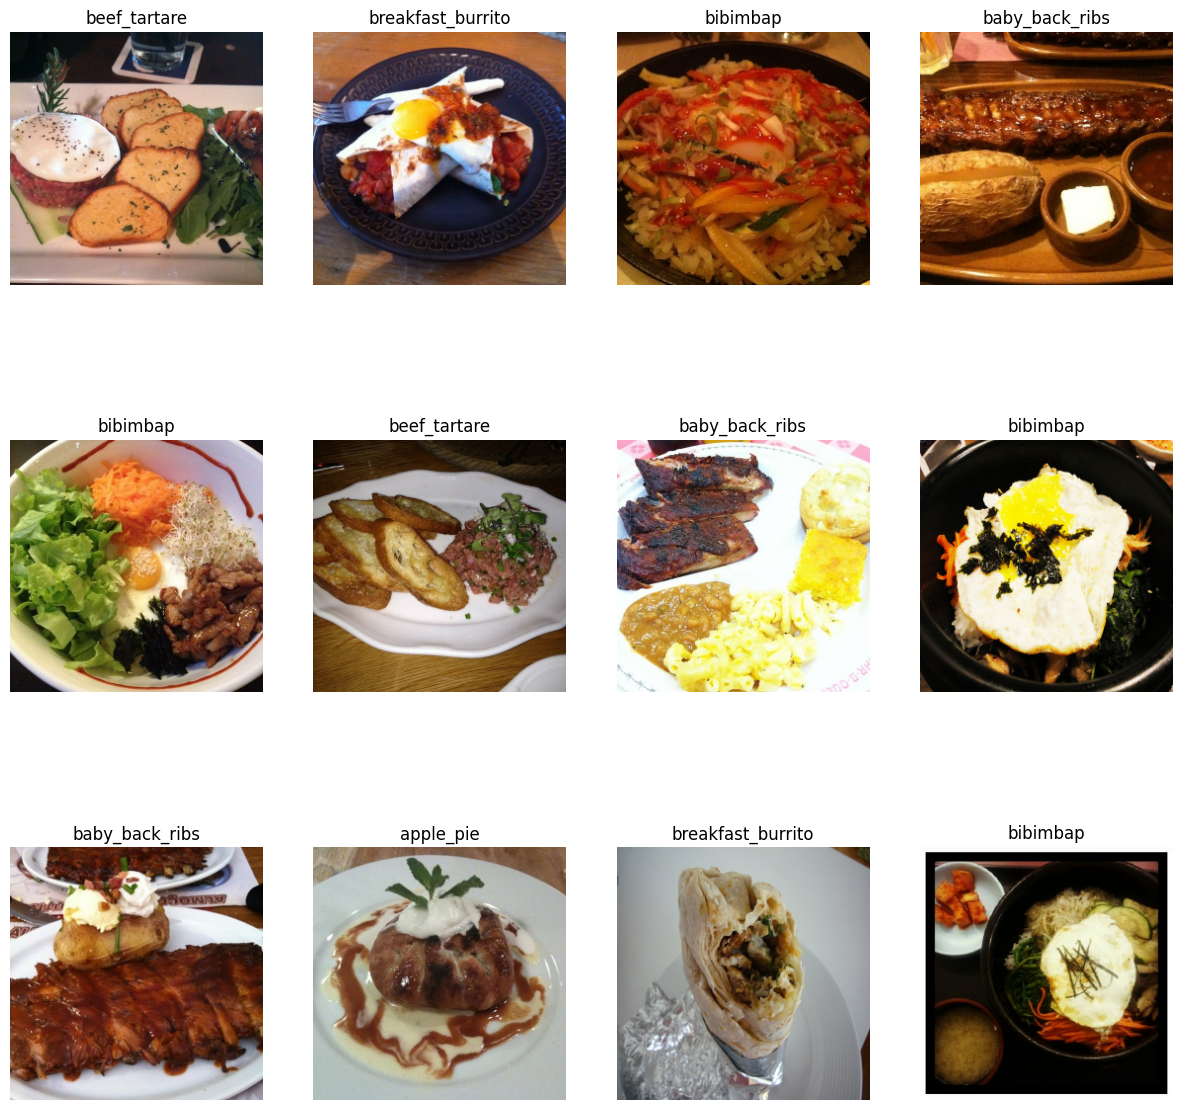

In [6]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):

  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis(False)

# Now that we have seen some of the images, is time to splitt the data into train, test and validation datasets

In [7]:
def split_data_tf(dds,
                  train_split = 0.7,
                  test_split = 0.15,
                  validation_split = 0.15,
                  shuffle = True,
                  shuffle_size = 1000000 # data will be shuffle to prevent repetitive selection
                  ):
  data_size = len(dds)
  if shuffle:
    dds = dds.shuffle(shuffle_size, seed = 0)

  train_size = int(train_split * data_size)
  test_size = int(test_split * data_size)

  train_dataset = dds.take(train_size)
  test_dataset = dds.skip(train_size).take(test_size)

  validation_dataset = dds.skip(train_size).skip(test_size)

  return train_dataset , test_dataset , validation_dataset

 # splitted dataset

train_dataset, test_dataset, validation_dataset = split_data_tf(dataset)



In [8]:
len(train_dataset)

110

In [9]:
len(test_dataset)

23

In [10]:
len(validation_dataset)

25

In [11]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size =
                                                             tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size =
                                                           tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size =
                                                                       tf.data.AUTOTUNE)

# ressize and resecale
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)

])

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_verstical"),
    layers.RandomRotation(0.2),
])

# Building the model

In [26]:
# This the sequence of Building the model for prediction

IMAGE_SIZE = 256
BATCH_SIZE = 32 #
EPOCHS = 50 # number of training iterations
CHANNELS = 3


input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

number_of_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (32, 256,256,3)),
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), # layer 1
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), #layers 2
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), # layer 3
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), # layers 4
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), # layer 5
    layers.MaxPooling2D((2,2)),

    # layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), # layer 6
    # layers.MaxPooling2D((2,2)),

    # layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), # layer 7
    # layers.MaxPooling2D((2,2)),

    # layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), # layer 8
    # layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(64, activation = 'relu'),
    layers.Dense(number_of_classes , activation = 'softmax'),
])


model.build(input_shape)

In [27]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (32, 5)                     │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer = 'Adam',
    #tf.keras.optimizers.Adam(learning_rate=1e-2),

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics = ['accuracy']
)

In [29]:
#Trianing the model


history = model.fit(train_dataset,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    validation_data = validation_dataset
                   )

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1117s 447ms/step - accuracy: 0.2328 - loss: 1.5876 - val_accuracy: 0.4005 - val_loss: 1.3648
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 55s 65ms/step - accuracy: 0.4106 - loss: 1.3377 - val_accuracy: 0.4496 - val_loss: 1.3285
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.4800 - loss: 1.2442 - val_accuracy: 0.4858 - val_loss: 1.1878
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.4913 - loss: 1.2066 - val_accuracy: 0.5375 - val_loss: 1.0901
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.5063 - loss: 1.1604 - val_accuracy: 0.4974 - val_loss: 1.2257
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.5414 - loss: 1.1134 - val_accuracy: 0.5749 - val_loss: 1.0719
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.5624 - loss: 1.0567 - val_accuracy: 0.6021 - val_loss: 1.0041
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.5850 - loss: 1.0156 - 

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 110}

In [32]:
acc = history.history["accuracy"]

loss = history.history["loss"]

val_acc = history.history["val_accuracy"]

val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and validation accuracy')

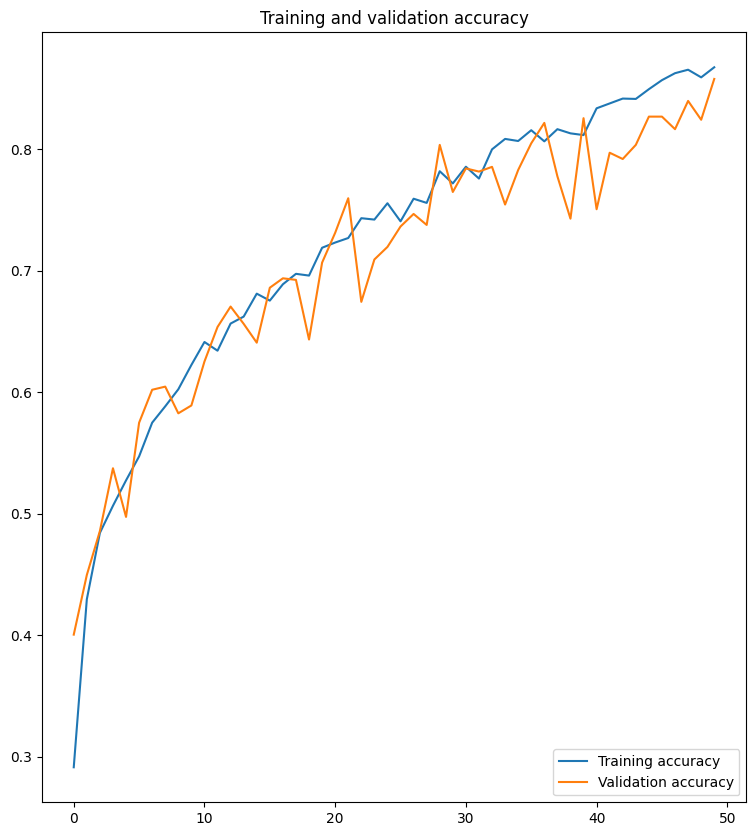

In [35]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label= "Training accuracy")
plt.plot(range(EPOCHS), val_acc, label ="Validation accuracy")
plt.legend(loc ="lower right")
plt.title("Training and validation accuracy")

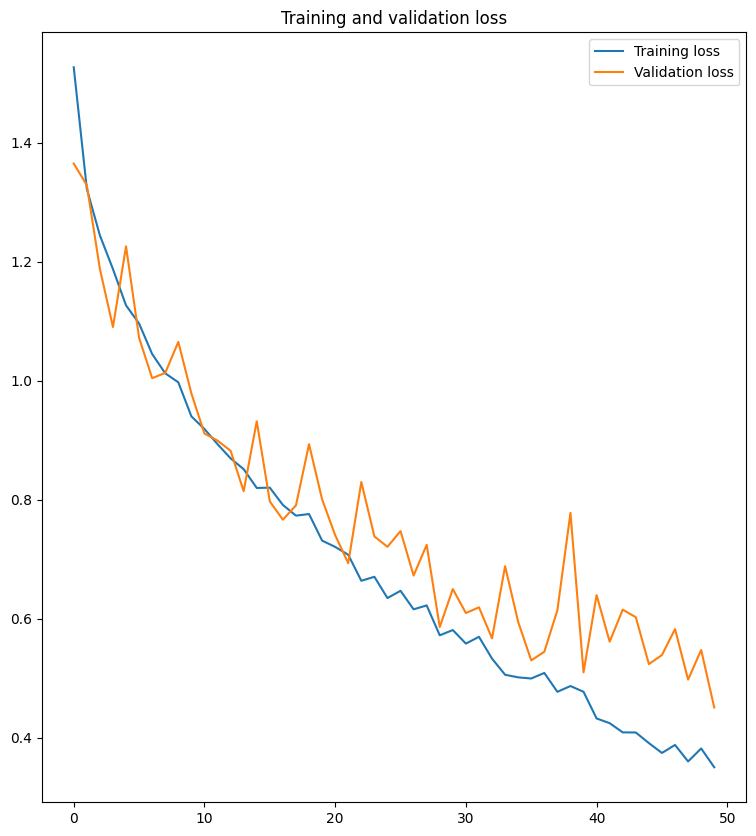

In [39]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label= "Training loss")
plt.plot(range(EPOCHS), val_loss, label ="Validation loss")
plt.legend(loc ="upper right")
plt.title("Training and validation loss");

First predicted image: 
Actual label :  apple_pie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
predicted label apple_pie


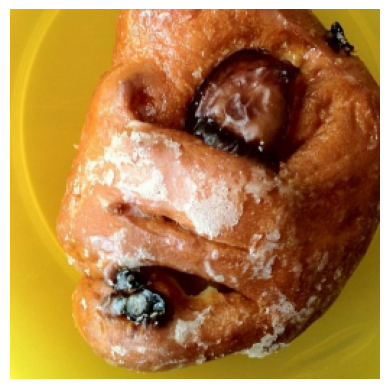

In [40]:
# Predicting an image from the test dataset
for image_batch, label_batch in test_dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.axis(False)
  first_image = image_batch[0].numpy().astype("uint8")
  first_label = label_batch[0].numpy()

  print("First predicted image: ")
  plt.imshow(first_image)
  print("Actual label : " , class_names[first_label])

  batch_predicted = model.predict(image_batch)
  print("predicted label",class_names[np.argmax(batch_predicted[0])]);

# Creating a function to make predictions

In [41]:
def predict(model, img):
  img_array  = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0) # create a batch

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

# Ploting predicted image vrs. Actual/true images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


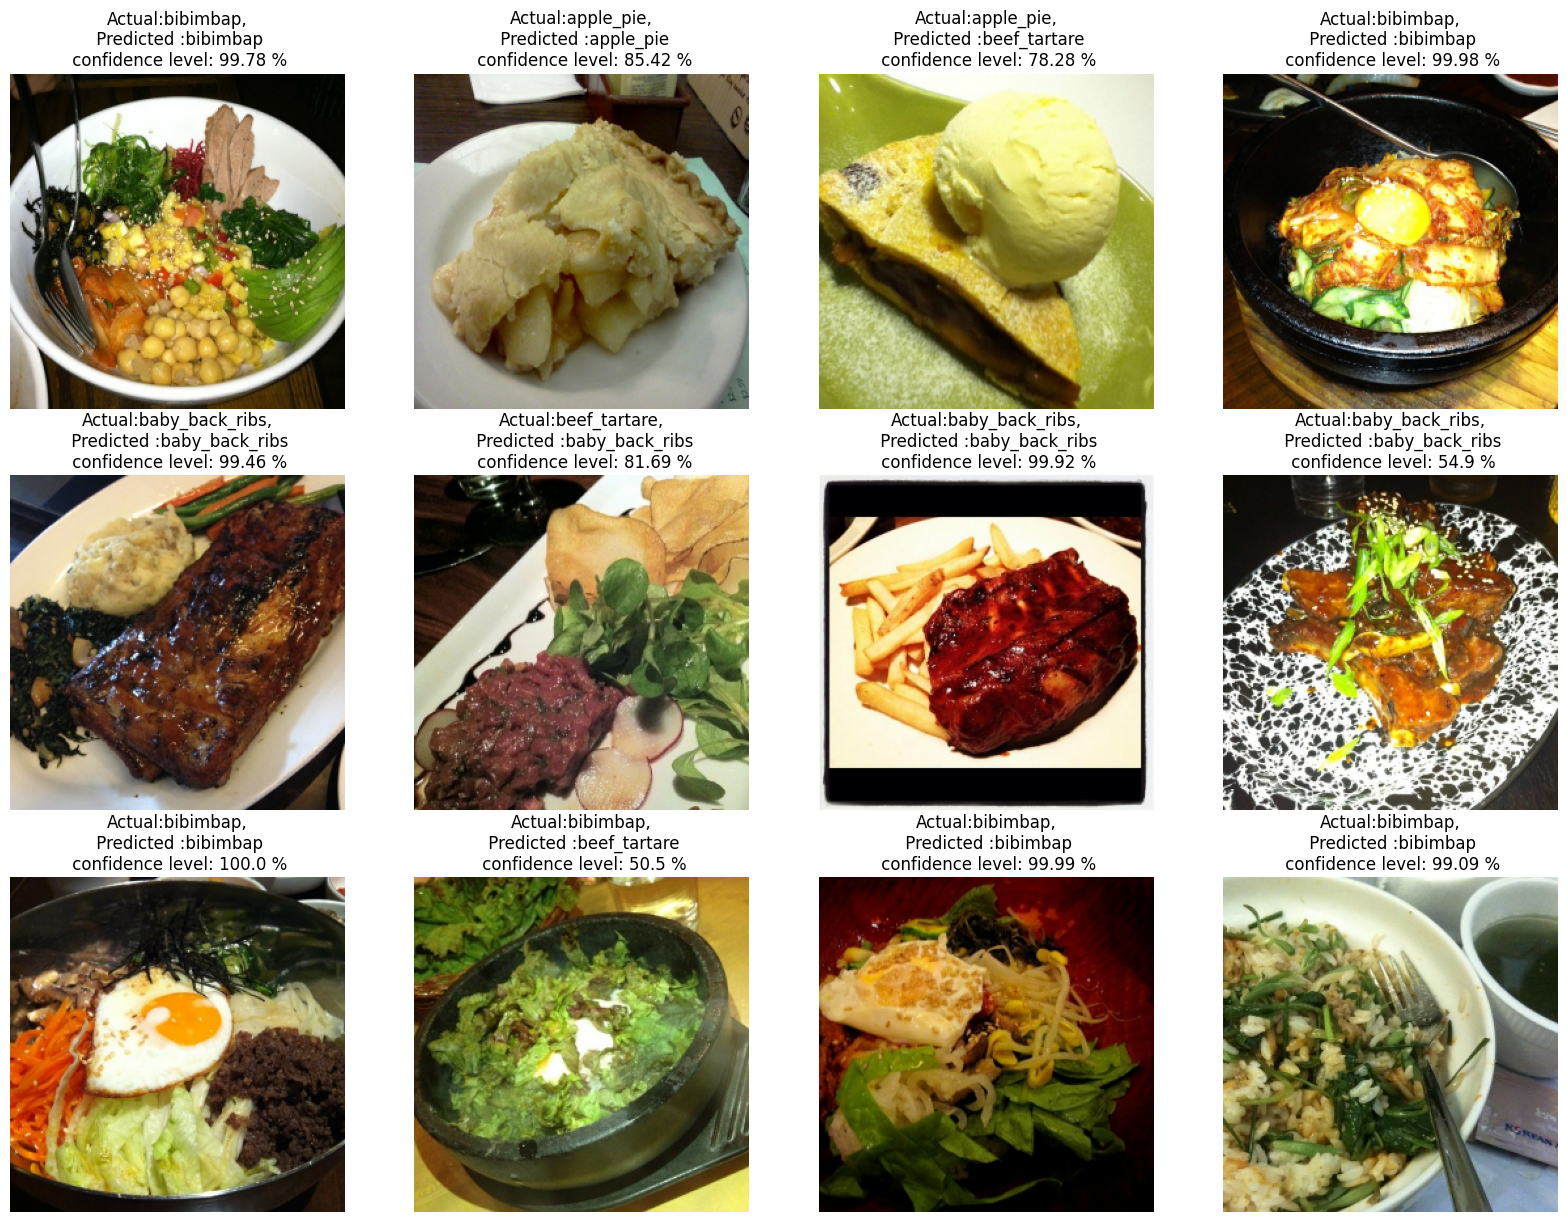

In [42]:
plt.figure(figsize=(20,20))

for images, labels in test_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual:{actual_class},\n Predicted :{predicted_class}\n confidence level: {confidence} %")
    plt.axis(False);